In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# importing the functions/variables from PA3_ReadData_and_Explore (code inspiration: stackoverflow.com)

In [2]:
import io, os, sys, types

In [3]:
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [4]:
def find_notebook(fullname='PA3_ReadData_and_Explore', path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [5]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [6]:
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}
    
    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return
        
        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)
        
        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [7]:
sys.meta_path.append(NotebookFinder())

In [26]:
import PA3_ReadData_and_Explore

In [9]:
df = PA3_ReadData_and_Explore.df

# Preprocessing/Working with the missing values

In [10]:
# checking to see if there are any NaN values
df.isnull().values.any()

True

Yes, there are NaN values.

In [11]:
# how many NaN values are there?
df.isnull().sum().sum()

33655

There are 33,655 NaN values. This is a huge count of values that are NaN.
We can fill in the missing values using the method "mean". I will use the mean of age groups and monthly incomes to fill in the mean values of all the features.

Age Group and Monthly Income, I think, are the most reasonable features for this dataset and the question at hand based on which I can extrapolate data for other features.

In [12]:
# applying average of different features values with respect to ZIP Code
# Pls note: in my PA2, the TA subtracted the marks for this function as I was using the mean values of variables to fill
# in the missing values. However, this function doesn't actually do that.

# This function uses the ZIP code to decide how NaN values should be filled. That is, a the figure of a zipcode 60615 with parents with
# average number of dependents will be used to fill in the missing values of other parents with missing values for their number of dependents.

def nan_values_fill(columns, group_by_column, df):
    for i in columns:
        if i != 'PersonID':
            df[i] = df.groupby(group_by_column)[i].apply(lambda x: x.fillna(x.mean()))
            df[i] = df[i].fillna(df[i].mean())
    return df

In [13]:
nan_values_fill(df.columns, 'zipcode', df).head()

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,60644,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,60637,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,60601,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,60601,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,60625,1,0.024926,63588.0,7,0,1,0,0.0


# Feature selection and preprocessing

In [14]:
# using extra trees classifier for feature selection
# This classifier is an ensemble classifier and thus uses an ensemble of parameters to come up with best parameters

In [15]:
# extracting out the output variable (Y) and one of the features i.e. Person ID for being irrelevant to feature selection
from sklearn.ensemble import ExtraTreesClassifier

def feature_selection(X, Y):
    # feature extraction
    model = ExtraTreesClassifier()
    model.fit(X, Y)
    important_features = model.feature_importances_
    return important_features

In [16]:
df_X = df.iloc[:,2:]
X = df_X
Y = df.iloc[:,[1]]
important_features = feature_selection(X, Y)
important_features

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


array([ 0.15180742,  0.11696702,  0.06908916,  0.06533341,  0.13899421,
        0.13268426,  0.09806135,  0.08671048,  0.04214853,  0.05805864,
        0.04014551])

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


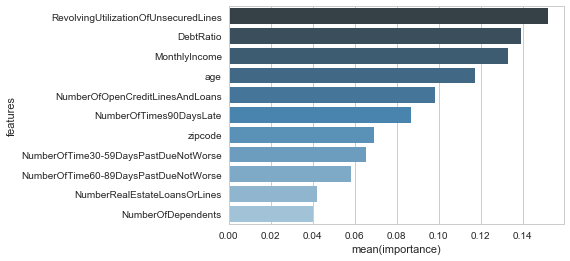

In [17]:
#code inspiration: data gotham
df_feature_importance = pd.DataFrame()
df_feature_importance['importance'] = important_features
df_feature_importance['features'] = df_X.columns
df_feature_importance = df_feature_importance.sort('importance', ascending=False)


#PA3_ReadData_and_Explore.seaborn_chart('importance', 'features', df_feature_importance, 'Importance Ratio')
sns.set_style("whitegrid")
ax = sns.barplot(x='importance', y='features', data=df_feature_importance, palette = "Blues_d")
sns.plt.show()

In [18]:
df_feature_importance[df_feature_importance['importance'] > 0.07]

,importance,features
0,0.151807,RevolvingUtilizationOfUnsecuredLines
4,0.138994,DebtRatio
5,0.132684,MonthlyIncome
1,0.116967,age
6,0.098061,NumberOfOpenCreditLinesAndLoans
7,0.086710,NumberOfTimes90DaysLate


In [19]:
def feature_selection_score(score, df_feature_importance):
    df_feature_importance = df_feature_importance[df_feature_importance['importance'] > score]
    df_important_cont_X = list(df_feature_importance.iloc[:3, 1])
    df_important_cat_X = list(df_feature_importance.iloc[3:, 1])
    return df_important_cont_X, df_important_cat_X

In [20]:
# selecting the features that have importance ratio of more than 0.08:
df_important_cont_X, df_important_cat_X = feature_selection_score(0.08, df_feature_importance)

In [21]:
# function to discreditize continous variables using Standard Scaler
from sklearn.preprocessing import StandardScaler

def transform_continuous_features(feature_name):
    # function to convert continuous variables into dummy varaibles.
    
    df[feature_name + '_scaled'] = StandardScaler().fit_transform(df[feature_name])

# Note: There are a couple of methods to convert the categorical variables into dummy variables. The easiest way to do is to use the get_dummies() function of pandas. I'll use that here instead of scikit's Hot Encoder, which does the same.

def transform_categorical_features(df_name, feature_name):
    # function to convert categorical variables into dummy varaibles.
    
    dummies = pd.get_dummies(df_name[feature_name], prefix=feature_name)
    df_name[dummies.columns] = dummies

In [22]:
# This for loop discreditizes all the columns that are most important.

def feature_standardization(columns, cont_list, cat_list, df_name):

    for feature in columns:
        if feature in cont_list:
            transform_continuous_features(feature)

        elif feature in cat_list:
            transform_categorical_features(df_name, feature)
            
    return df_name

In [23]:
df = feature_standardization(df_X.columns, df_important_cont_X, df_important_cat_X, df)

/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.resha

In [24]:
df_important_features = df.iloc[:,13:]

In [25]:
df.head()

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,...,NumberOfTimes90DaysLate_9,NumberOfTimes90DaysLate_10,NumberOfTimes90DaysLate_11,NumberOfTimes90DaysLate_12,NumberOfTimes90DaysLate_13,NumberOfTimes90DaysLate_14,NumberOfTimes90DaysLate_15,NumberOfTimes90DaysLate_17,NumberOfTimes90DaysLate_96,NumberOfTimes90DaysLate_98
0,1,1,0.766127,45,60644,2,0.802982,9120.0,13,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0.957151,40,60637,0,0.121876,2600.0,4,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0.658180,38,60601,1,0.085113,3042.0,2,1,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0.233810,30,60601,0,0.036050,3300.0,5,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0.907239,49,60625,1,0.024926,63588.0,7,0,...,0,0,0,0,0,0,0,0,0,0
